<a href="https://colab.research.google.com/github/Byeongali/CS50/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Unsupervised Learning

## Version history

| Date | Author | Description |
|:----:|:------:|:------------|
2021-02-17 | Josiah Wang | First version | 
2021-02-19 | Josiah Wang | Added equations for EM | 
2021-11-11 | Josiah Wang | The colour dataset is no longer available online. Updated to point to the conference paper instead. |
2023-01-22 | Josiah Wang | Updated link to dataset. |

## Introduction

The aim of this lab exercise is to give you some practical experience in implementing unsupervised learning algorithms as discussed in the lectures. This will hopefully help improve your understanding of the algorithms. 

By the end of this lab exercise, you will have 
- run some clustering algorithms using scikit-learn's implementation
- implemented a working Kernel Density estimator
- implemented and fitted a Gaussian distribution model
- implemented the Expectation-Maximization (EM) algorithm to fit a Gaussian Mixture Model


## A dataset of blue pixels

Let us try to improve your understanding of unsupervised learning by tackling a concrete and interesting problem. You will work with a real(-ish) but simple dataset.

Background information: A pixel can be represented by three features: R (red), G (green) and B (blue). Each feature can be between 0.0 and 1.0 (inclusive). The combination of these measurements will produce an observable colour on your screen. For example, R=1.0, G=0.6, B=0.0 will result in a pixel that you will perceive as orange.

You are provided with a dataset containing examples of "blue" pixels. Obviously, "blue" can be in different shades and intensity, and what you might perceive as "blue" might not be perceived as such by another person (e.g. I would say that is turquoise!)

The code below will download a dataset of 100,000 "blue" pixels that I have prepared. If you run the code, you will see that the dataset contains different shades of blue (along with some noise).

[For those really interested, I obtained these pixels by extracting all pixels containing the word "blue" in the label of the dataset [from this paper](https://aclanthology.org/Q15-1008.pdf), and then sampled 100,000 of them at random. The original dataset was actually obtained by asking people on the Web to name the colour shown. More details can be found in [this blog article](https://blog.xkcd.com/2010/05/03/color-survey-results/), in case you find that interesting.]

--2023-02-21 22:20:16--  https://www.doc.ic.ac.uk/~jwang4/files/intro2ml/blue_rgb_sample.txt
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2200000 (2.1M) [text/plain]
Saving to: ‘blue_rgb_sample.txt’

blue_rgb_sample.txt 100%[===================>]   2.10M  2.32MB/s    in 0.9s    

2023-02-21 22:20:18 (2.32 MB/s) - ‘blue_rgb_sample.txt’ saved [2200000/2200000]

(100000, 3)


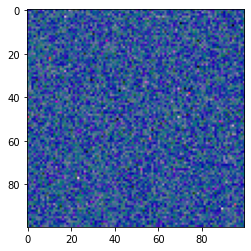

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Download dataset if it does not exist
if not os.path.exists("blue_rgb_sample.txt"):
    !wget -O blue_rgb_sample.txt https://www.doc.ic.ac.uk/~jwang4/files/intro2ml/blue_rgb_sample.txt

x_train = []
for line in open("blue_rgb_sample.txt"):
    r, g, b = line.strip().split(",")
    x_train.append(list(map(float, [r, g, b])))

x_train = np.array(x_train)  # (100000, 3), each row is an RGB measurement
print(x_train.shape)  

# Visualise the colour of the first 10,000 pixels.
# Reshape the 10,000 pixels into a grid for visualisation
# The 3rd dimension contains the R, G and B of each pixel
# This allows plt.imshow() to display an RGB image
# Feel free to change n_cols and n_rows below to visualise fewer pixels (more clearly)
n_cols = 100
n_rows = 100
plt.imshow(np.reshape(x_train[:n_rows*n_cols, :], (n_rows, n_cols, 3)))
plt.show()

        

## Clustering

You will have noticed that there are many different shades of blue in this dataset - light blue, dark blue, greenish blue, almost blacks, purples, etc. Let us try to cluster the blues into multiple groups! 


### Running $K$-means

We will not go through implementing $K$-means from scratch as it is relatively straightforward. Of course, feel free to try implementing your own 'vanilla' $K$-means if you would like to gain a deeper understanding.

We will instead apply scikit-learn's implementation of the $K$-means algorithm to cluster our blue pixel dataset, and see whether we can discover different variants of blue!

The code below will cluster a small subset of the blue pixel dataset into a fixed number of clusters.

It will then visualise the clusters by showing some examples from each cluster.

Try increasing the number of clusters and observe the effect. 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[1 1 1 0 2 0 1 0 1 2 2 2 0 1 2 2 2 0 1 0 0 2 0 2 1 0 1 0 2 1 2 0 2 2 1 1 2
 1 2 0 1 2 0 0 0 2 0 2 0 2 1 1 0 1 1 2 2 1 2 1 2 0 0 0 2 1 0 2 2 0 2 2 2 2
 2 1 2 0 2 0 1 0 2 1 1 1 2 2 2 0 2 1 0 1 1 2 1 2 2 2 2 0 1 2 2 1 1 1 0 0 2
 1 0 2 2 2 2 0 2 0 0 2 0 0 2 0 2 0 2 1 2 2 2 1 0 2 2 2 0 1 2 2 1 2 2 0 0 1
 1 0 0 2 0 0 2 1 1 0 2 2 1 2 1 0 2 1 1 2 0 1 2 2 0 0 0 2 1 2 1 1 0 0 0 0 0
 1 0 2 0 2 1 2 0 2 2 0 1 0 2 2 1 0 2 1 1 2 2 2 0 1 0 0 1 2 0 1 0 1 0 0 0 0
 1 2 2 2 1 0 0 0 1 2 1 2 1 0 2 0 2 0 1 1 0 1 1 2 2 2 2 2 2 2 0 1 2 1 2 2 0
 1 2 1 2 0 1 1 1 1 2 0 0 1 1 1 0 0 2 0 0 1 1 2 1 0 0 2 0 2 2 1 1 2 1 2 2 0
 1 1 1 0 1 2 0 1 1 0 2 2 1 0 0 0 0 2 0 2 1 0 0 2 0 2 1 0 1 2 0 1 1 0 0 0 2
 2 2 2 2 1 2 0 0 1 0 1 2 2 1 1 0 2 2 2 0 1 0 1 0 0 2 0 0 0 0 0 0 0 1 0 2 2
 1 0 0 0 0 2 1 2 1 1 2 0 2 0 0 2 0 1 0 2 1 1 1 1 0 1 0 2 2 0 1 2 0 0 2 0 1
 1 2 2 1 2 1 2 1 2 2 0 1 1 1 2 2 1 2 2 1 0 2 1 0 0 0 0 1 0 0 2 0 1 2 0 0 0
 

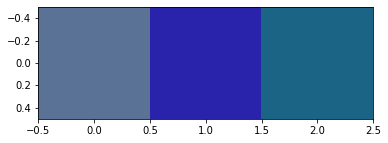

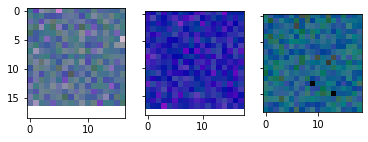

In [2]:
!pip install scikit-learn

from sklearn.cluster import KMeans

# we will work with a small subset of the data to save time and memory
# increase it if you like!
x_subset = x_train[:1000]

n_clusters = 3

clusters = KMeans(n_clusters=n_clusters).fit(x_subset)

print(clusters.labels_)
print(clusters.cluster_centers_)

# Visualise cluster centres
plt.imshow(np.reshape(clusters.cluster_centers_, (1, -1, 3)))
plt.show()

# Visualise clusters by showing some examples from each cluster
dims = x_subset.shape[1]
fig, axes = plt.subplots(1, n_clusters, sharey=True)

for k in range(n_clusters):
    points = x_subset[clusters.labels_ == k, :]

    # reshape pixels into the closest "square" grid possible for visualisation
    n_rows = np.floor(np.sqrt(len(points))).astype(int)
    n_cols = n_rows
    axes[k].imshow(np.reshape(points[:n_rows*n_cols, :], (n_rows, n_cols, dims)))


### Elbow method

You can also attempt to use the elbow method to determine the optimal number of clusters. Run the code below to get a plot. Unfortunately, here we have an example of the elbow method not working too well. Where is the elbow? I have no definite answer myself. 😢

28.007270594457562
18.506415127740162
15.476626056155709
12.984020828138307
10.702764230907425
9.236423993226385
7.962202890143953
7.228804111909408
6.622964762655489
6.107464002477403
5.639395699709507
5.191313898263431
4.737217297720283


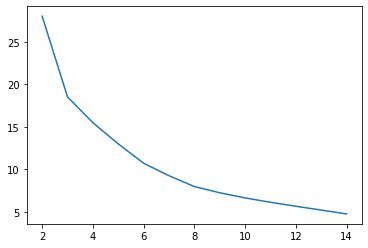

In [4]:
cluster_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
scores = []
for n_clusters in cluster_list:
    clusters = KMeans(n_clusters=n_clusters).fit(x_subset)
    score = clusters.inertia_  # sum of squares to centroid
    print(score)
    scores.append(score)

plt.plot(cluster_list, scores)
plt.show()


### Other clustering algorithms

You can also explore the other clustering algorithms provided by scikit-learn. The [official documentation](https://scikit-learn.org/stable/modules/clustering.html) provides details about many of these clustering algorithms - feel free to read in your own time. You can use the code below to experiment.

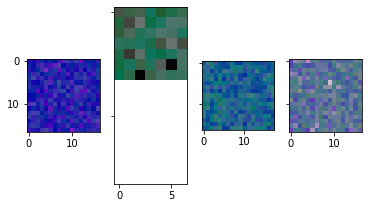

In [5]:
from sklearn.cluster import SpectralClustering, AgglomerativeClustering

n_clusters = 4

clusters = SpectralClustering(n_clusters=n_clusters).fit(x_subset)
#clusters = AgglomerativeClustering(n_clusters=n_clusters).fit(x_subset)

#print(clusters.labels_)

# Visualise clusters by showing some examples from each cluster
dims = x_subset.shape[1]
fig, axes = plt.subplots(1, n_clusters, sharey=True)

for k in range(n_clusters):
    points = x_subset[clusters.labels_ == k, :]
    n_rows = np.floor(np.sqrt(len(points))).astype(int)
    n_cols = n_rows
    axes[k].imshow(np.reshape(points[:n_rows*n_cols, :], (n_rows, n_cols, dims)))


## Density Estimation

We will now tackle another unsupervised learning problem - density estimation. 

Your task now is to model and discover what a "blue" pixel should look like. Your model should be able to estimate how likely a given RGB pixel is to be "blue".

Intuitively, you model should produce a high density estimate when a pixel is likely to be "blue" according to the dataset, and a low density estimate when presented with a red pixel for example. 

Let us first produce some examples for testing whether our density estimators are working sensibly. Run the code below to generate some hand-picked test examples.


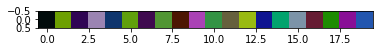

In [6]:
# 20 test examples of different colours
x_test = np.array([[0.01, 0.05 ,0.05],
                    [0.43, 0.63 ,0.01],
                    [0.19, 0.02 ,0.33],
                    [0.61, 0.52 ,0.70],
                    [0.06, 0.21 ,0.43],
                    [0.38, 0.63 ,0.05],
                    [0.25, 0.04 ,0.31],
                    [0.32, 0.59 ,0.20],
                    [0.30, 0.09 ,0.01],
                    [0.67, 0.26 ,0.71],
                    [0.20, 0.58 ,0.27],
                    [0.40, 0.38 ,0.24],
                    [0.60, 0.73 ,0.07],
                    [0.06, 0.08 ,0.57],
                    [0.01, 0.64 ,0.43],
                    [0.49, 0.58 ,0.66],
                    [0.40, 0.11 ,0.20],
                    [0.12, 0.55 ,0.01],
                    [0.54, 0.06 ,0.59],
                    [0.14, 0.34 ,0.69]]) 

# Visualise the 20 pixels
plt.imshow(np.reshape(x_test, (1, -1, 3)))
plt.show()

### Non-parametric approach: Kernel density estimation

We will first take the non-parametric approach and model "blue" pixels using Kernel Density Estimation, as described in the lectures.

#### Scikit-learn's implementation

Let us first try to get a feel of Kernel Density Estimation by using scikit-learn's implementation.
Examine the code below, and then run it and observe the output. You should see reasonably high density values for blue-ish instances. 

Change the bandwidth and observe the effect on the density values. Try both lower and higher bandwidth.

You can also experiment with different kernels and distance metrics if you wish. Consult the official [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html) and [user guide](https://scikit-learn.org/stable/modules/density.html#kernel-density) for these.


[0.21216695 0.18942606 0.33785884 0.30710042 0.41491901 0.21434051
 0.33551929 0.29996493 0.209124   0.29163425 0.34171021 0.33651302
 0.15556657 0.40038787 0.34633968 0.34752664 0.28721179 0.22285901
 0.32131163 0.45056021]


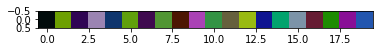

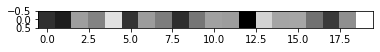

In [17]:
import sklearn.neighbors

kd = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=0.5)
kd.fit(x_train)
pde = kd.score_samples(x_test)

# sklearn's KernelDensity produces log likelihoods
# convert it back to likelihood with exp() 
print(np.exp(pde))

# plot test instances
plt.imshow(np.reshape(x_test, (1, -1, 3)))
plt.show()

# plot pde of test instances: lighter = higher density
plt.imshow(np.reshape(np.exp(pde), (1, -1)), cmap="gray") 
plt.show()

#### Your implementation

Now, you will implement your own Kernel Density Estimator to gain a better understanding of its details.

As in the lectures, we will use a Gaussian kernel.

$$\hat{p}(x) = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{(2 \pi h^2)^\frac{D}{2}} \exp{\left(- \frac{||x - x^{(i)}||^2}{2h^2} \right)}$$

where 
- $h$ is the bandwidth
- $||x - x^{(i)}||^2 = (x_1-x_1^{(i)})^2 + (x_2-x_2^{(i)})^2 + \dotsc + (x_D-x_D^{(i)})^2$ is the sum of squared distance between a test instance $x$ and a training instance $x^{(i)}$ 
- $D$ is the number of features (3 in our case). 

Since $\frac{1}{(2 \pi h^2)^\frac{D}{2}}$ is a constant, we can move it to the outside of the summation for our convenience.

$$\hat{p}(x) = \frac{1}{(\sqrt{2 \pi} h)^D} \frac{1}{N} \sum_{i=1}^{N}  \exp{\left(- \frac{||x - x^{(i)}||^2}{2h^2} \right)}$$

Since the Kernel Density Estimator is a "lazy learner", all the computation will be done at test time. The `.fit()` method of `KernelDensity` below only stores the training examples.

Complete the `.pdfs()` method of `KernelDensity` below to compute the density estimate (likelihood) for each given test sample `x_test`. If implemented correctly, you should be able to get the same output as scikit-learn's implementation above.



In [ ]:
class KernelDensity:
    def __init__(self, h=1):
        self.h = h        
        self.x = np.array([])

    def fit(self, x):
        """ Store the training examples

        Args:
            x (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
        """        
        self.x = x


    def pdfs(self, x_test):
        """ Compute the likelihood for a set of test instances

        Args:
            x_test (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
                            
        Returns:
            np.ndarray: shape (N, ) containing the density estimate for each N instance
        """

        dim = self.x.shape[1]

        # For storing the pairwise distances between test and training instances
        distances = np.zeros((len(x_test), len(self.x)))

        for (i, x) in enumerate(x_test):
            # TODO: Complete this.
            # You will only need to implement the bit inside the summation
            # i.e. the exp(- ... )
            raw_distance_squares = self.x - x
            distances[i, :] = np.exp(-1 / (2 * self.h**2) * (x**2 + self.x **2 - 2 * x * self.x.transpose()))

        density = distances.mean(axis=1) / (np.sqrt(2*np.pi)*self.h)**dim
        return density


# Test your model
my_kd = KernelDensity(h=0.5)
my_kd.fit(x_train)
pde = my_kd.pdfs(x_test)

print(pde)

# plot test instances
plt.imshow(np.reshape(x_test, (1, -1, 3)))
plt.show()

# plot pde of test instances: lighter = higher density
plt.imshow(np.reshape(pde, (1, -1)), cmap="gray") 
plt.show()



Here is a larger test set where I generated many possible combinations of RGB values. Run the code below - note that it will be much slower to compute than the previous test set!

In [ ]:
# Generate evenly spaced test instances
# 0.0 0.0 0.0
# 0.0 0.0 0.1
# 0.0 0.0 0.2
# ...
# 1.0 1.0 0.9
# 1.0 1.0 1.0

points = np.arange(0, 1.01, 0.1)
(r_test, g_test, b_test) = np.meshgrid(points, points, points)
x_test_large = np.vstack((r_test.ravel(), g_test.ravel(), b_test.ravel())).transpose()

pde = my_kd.pdfs(x_test_large)
print(pde)

plt.imshow(np.reshape(x_test_large, (11, 121, 3)))
plt.show()
plt.imshow(np.reshape(pde, (11, 121)), cmap='gray')
plt.show()


### Parametric approach: Gaussian distribution

Next, we will explore the simpler parametric approach to density estimation, by modelling "blue" with a multivariate Gaussian distribution. You will assume that there is an 'average' blue, with the variation across the R, G and B measurements captured by a covariance matrix. 


#### Your implementation

Firstly, complete the `.fit()` method of `Gaussian` below. This is simply a matter of computing the mean and the covariance matrix from `x`. 

$\mathbf{\hat{\mu}} = \frac{1}{N} \sum_{i=1}^N \mathbf{x}^{(i)}$

$\hat{\Sigma} = \frac{1}{N} \sum_{i=1}^N (\mathbf{x}^{(i)} - \mathbf{\hat{\mu}}) (\mathbf{x}^{(i)} - \mathbf{\hat{\mu}})^T$

Depending on how far you want to go and how comfortable you are with linear algebra, you can compute the mean and covariance from scratch by implementing the equations above. You can also just use NumPy's functions for this to make life easier: `numpy.mean()` or `numpy.cov()`. 

If using `numpy.cov()`, remember to transpose `x` (it expects a $dim \times N$ numpy array), and specify `ddof=0` as a keyword argument so that it uses $N$ rather than $N-1$ in the denominator. $N$ is often used in Machine Learning to estimate the (co)variance as derived from the Maximum Likelihood Estimate.

Once you are done, then complete the `.pdf()` method of `Gaussian`, which computes the density estimate for *one* instance. Again, you can implement the equation below from scratch, or just use the `.pdf()` method of `scipy.stats.multivariate_normal()` for this. 

$\mathcal{N}(\mathbf{x} | \mathbf{\mu}, \Sigma) = \frac{1}{\sqrt{(2 \pi)^D |\Sigma|}} \cdot \exp^{\left(- \frac{1}{2} (\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu})\right)}$

These NumPy functions might be useful if you are implementing the equation from scratch:
- `numpy.linalg.inv()` to compute the inverse of a matrix
- `numpy.linalg.det()` to compute the determinant of a matrix

I will provide an example implementation for both in the solutions. Feel free to study the solutions if you are feeling confused or overwhelmed - you have my permission!

In [ ]:
import scipy.stats

class Gaussian:
    def __init__(self):
        self.mu = None      # (D, ) np.ndarray
        self.sigma = None   # (D, D) np.ndarray

    def fit(self, x):
        """ Fit the data to a Gaussian distribution

        Args:
            x (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
        """  

        ## TODO: Complete these
        self.mu = ????
        self.sigma = ???? 

        
    def pdf(self, x):
        """ Compute the likelihood for a single test instance

        Args:
            x (np.ndarray): shape (D, ) where D is the number of features
                            
        Returns:
            float: the density estimate for x
        """

        # TODO: Complete this
        return ????


    def pdfs(self, x_test):
        """ Compute the likelihood for a set of test instances

        Args:
            x_test (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
                            
        Returns:
            np.ndarray: shape (N, ) containing the density estimate for each N instance
        """        

        lik = np.zeros((len(x_test),))
        for i in range(len(x_test)):
            lik[i] = self.pdf(x_test[i, :])
        return lik


print("Your estimated Gaussian distribution")
model = Gaussian()
model.fit(x_train)
print(model.mu)
print(model.sigma)

print("\nTesting your Gaussian distribution")
pde = model.pdfs(x_test)
print(pde)

# plot the mean
plt.imshow(np.reshape(model.mu, (1, -1, 3)))
plt.show()

# plot test instances
plt.imshow(np.reshape(x_test, (1, -1, 3)))
plt.show()

# plot pde of test instances: lighter = higher density
# plotting the log(pde) this time for better visibility 
plt.imshow(np.reshape(np.log(pde), (1, -1)), cmap="gray") 
plt.show()


# use this to check your expected output
print("=====================")
print("Scikit-learn's output")
import sklearn.mixture
sklearn_model = sklearn.mixture.GaussianMixture(n_components=1, 
                        init_params='random', 
                        covariance_type='full', 
                        verbose=0, 
                        reg_covar=0.)
sklearn_model.fit(x_train)
print(sklearn_model.means_.squeeze())
print(sklearn_model.covariances_.squeeze())
log_prob = sklearn_model.score_samples(x_test)
print(np.exp(log_prob))

plt.imshow(np.reshape(sklearn_model.means_.squeeze(), (1, -1, 3)))
plt.show()

#### Generating samples

Gaussian distributions are **generative models**. Thus, you will also be able to generate samples of "blue" pixels from the model you have just fitted. 

The code below will generate 100 samples of "blue" pixels from your Gaussian distribution of "blue".

In [ ]:
rg = np.random.default_rng(seed=60012)
samples = rg.multivariate_normal(model.mu, model.sigma, 100)

# keep samples inside the desired range
samples[samples < 0] = 0.
samples[samples > 1] = 1.

plt.imshow(np.reshape(samples, (10, 10, 3)))
plt.show()

### Semi-parametric approach: Gaussian Mixture Models

Gaussian distributions may be simple and efficient, but may be too simple to model data that is more complex. Kernel density estimators on the other hand are more expressive and can model complex data, but is very slow to compute at test time. Gaussian Mixture Models (GMMs) offer the best of both worlds: the simplicity of Gaussian distributions and the expressiveness of Kernel density estimators. 


#### Scikit-learn's implementation

We will start with scikit-learn's implementation and try to get the hang of how GMMs work. Run the code below. Experiment with the number of components; the higher the number of components, the more expressive the GMM becomes, but the slower it will take to run.

In [ ]:
import sklearn.mixture

n_components = 3

gmm = sklearn.mixture.GaussianMixture(n_components=n_components, 
                    init_params='random', 
                    covariance_type='full',
                    verbose=2,           # give lots of information
                    verbose_interval=1,  # show stats at every 1 iteration
                    reg_covar=0.         # this argument is to ensure that the covariance matrix is always positive. Disabled this for now.
                    )

x_subset = x_train

gmm.fit(x_subset)

print(gmm.n_iter_)
print(gmm.weights_)        
print(gmm.means_)
print(gmm.covariances_)  

# Plot the means of each component
plt.imshow(np.reshape(gmm.means_, (1, -1, 3)))
plt.show()

pde = gmm.score_samples(x_test)
print(np.exp(pde))

# plot test instances
plt.imshow(np.reshape(x_test, (1, -1, 3)))
plt.show()

# plot pde of test instances: lighter = higher density
# plotting the log(pde) this time for better visibility 
plt.imshow(np.reshape(pde, (1, -1)), cmap="gray") 
plt.show()

# sample 100 examples from the GMM
(samples, labels) = gmm.sample(100)
samples[samples < 0] = 0.
samples[samples > 1] = 1.
print("\nSampling 100 instances from the GMM")
plt.imshow(np.reshape(samples, (10, 10, 3)))
plt.show()
print("\nLabels of the 100 samples")
print(labels)

#### Your implementation

Now it is your turn to implement your own GMM, or more specifically the Expectation Maximization (EM) algorithm to optimise the GMM's parameters. The EM algorithm itself is not difficult, but implementing it correctly from scratch can take some effort. Otherwise scikit-learn's implementation will be more than enough for most practical purposes.

The aim of this section is more to improve your understanding of EM by getting your hands dirty, rather than trying to produce the most efficient implementation. The 1D example in tutorial worksheets is already be sufficient for the exam and for improving your understanding. Implementing a multivariate version will bring your understanding to the next level as you will have to start thinking about covariance matrices and all the nuances of linear algebra. So, please do attempt it if/when you have spare time and are up for a challenge! 

I have provided most of the skeleton code (check out `.fit()` for the main algorithm). You should complete the following methods:
- `_e_step()`: To perform an Expectation step
- `_m_step()`: To perform a Maximization step
- `pdf()`: To compute the GMM likelihood on a single test instance

Tip: Make sure you know exactly the dimensions of the matrices that you need before coding. It is mainly about getting the matrices and matrix operations correct. Guessing does not quite work here and will only waste your time! Also beware of [NumPy's array broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html), especially if you do not know what you are doing!

Here are the equations from the lectures (I swapped the $k$ and $i$ in $r_{ki}$ just to be consistent with the implementation below):
- E-step

$r_{ki} = \frac{\pi_k \mathcal{N}(\mathbf{x}^{(i)} | \mathbf{\mu}_k, \Sigma_k)}{\sum_j^K \pi_j \mathcal{N}(\mathbf{x}^{(i)} | \mathbf{\mu}_j, \Sigma_j)}$

- M-step

$N_k = \sum_{i=1}^N r_{ki}$

$\pi_k = \frac{N_k}{N}$

$\mathbf{\hat{\mu}}_k = \frac{1}{N_k} \sum_{i=1}^N r_{ki} \mathbf{x}^{(i)}$

$\mathbf{\Sigma}_k = \frac{1}{N_k} \sum_{i=1}^N r_{ki}\left( \mathbf{x}^{(i)} - \mathbf{\hat{\mu}}_k \right) \left( \mathbf{x}^{(i)} - \mathbf{\hat{\mu}}_k \right)^T$

- PDF

$p(\mathbf{x}|\theta) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu_k}, \Sigma_k)$




In [ ]:
class GaussianMixtureModel:
    def __init__(self, k):
        self.k = k

        # Initialise mixing proportions with uniform weights
        self.pi = np.ones((self.k, )) / self.k

        # Initialise with empty components. We will reuse our Gaussian class from earlier.
        self.components = [Gaussian() for i in range(self.k)] 


    def _init_params(self, x):
        """ Initialise the parameters of the GMM. 
        
        The mixing proportions (self.pi) have already been initialised in the constructor, 
        so what's left is to initialise the means and covariances for each component 

        Args:
            x (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
        """

        # Initialise the mu and sigma for each component
        # Select k random instances from x to use as mean for each component
        # Initialise the covariance for each component as the covariance of the x

        # select k random instances
        rg = np.random.default_rng(seed=60012)
        random_indices = rg.choice(len(x), self.k)

        # compute the covariance of the whole dataset
        covar = np.cov(x.T, ddof=0)

        # Initialise the mean and covariance for each component
        for k in range(self.k):
            self.components[k].mu = x[random_indices[k], :]
            self.components[k].sigma = covar


    def _fit_sklearn_gmm(self, x):
        """ Fit a GMM with scikit-learn to compare with our implementation

        Initialise with our own parameters to try to reproduce our own implementation

        Note: I found that scikit-learn's convergence check is off by one iteration
        compared to my own implementation, but otherwise I managed to reproduce its
        output (assuming you can stop its iteration at one step before - 
        use max_iter below to control this)

        Args:
            x (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features        
        """
        gmm = sklearn.mixture.GaussianMixture(n_components=n_components, 
                    init_params='random', 
                    weights_init=self.pi,
                    means_init=[self.components[k].mu for k in range(self.k)],
                    precisions_init=[np.linalg.inv(self.components[k].sigma) for k in range(self.k)],
                    covariance_type='full',
                    verbose=2,
                    verbose_interval=1,
                    tol=1e-3,      # tolerance for convergence check
                    #max_iter=1,   # change this to stop at a specific iteration for inspection purposes
                    reg_covar=0.)
        gmm.fit(x)

        print(gmm.n_iter_)
        print(gmm.weights_)
        print(gmm.means_)
        print(gmm.covariances_)

        #print(gmm.score_samples(x_test))


    def _compute_average_loglikelihood(self, x):
        """ Compute the average loglikelihood of the data

        I am using the average loglikelihood here rather than the sum as in the lectures.
        This is so that I can compare it to scikit-learn's average loglikelihood 
        """
        
        # Compute unweighted likelihoods for x per component
        lik = self._compute_component_likelihood(x)

        # Weighted sum across components, and sum the loglikelihood across N instances
        loglik = 0
        for i in range(len(x)):
            loglik += np.log(np.dot(self.pi, lik[:, i]))

        # Return the average log likelihood
        return loglik / len(x)


    def _compute_component_likelihood(self, x):
        """ Compute the unweighted per-component likelihood of the data

        Args:
            x (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
                            
        Returns:
            np.ndarray: shape (K, N) containing the likelihood for each component and each instance
        """
        
        lik = np.zeros((self.k, len(x)))  # k x N
        for k in range(self.k):
            lik[k, :] = self.components[k].pdfs(x)

        return lik


    def _e_step(self, x):
        """ Perform a single E-step of EM

        Compute and return the responsibilities per component per instance

        Args:
            x (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
                            
        Returns:
            np.ndarray: shape (K, N) containing the responsibilities for each component and each instance
        """

        # Compute the (unweighted) likelihood for each component, for each instance
        # this will be the N(x|mu_k, sigma_k) for each component
        # You may use this in your calculations
        lik = self._compute_component_likelihood(x)

        # TODO: Compute posterior/responsibilities
        r = ????

        return r


    def _m_step(self, x, r):
        """ Perform a single M-step of EM

        Update the parameters (weights, means, convariances) of the GMM

        Args:
            x (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
            r (np.ndarray): shape (K, N) containing the responsibilities for each component and each instance
        """

        # Sum the responsibilities for each component
        # You may use this in your calculations
        r_sum = np.sum(r, axis=1)    # (k, )

        ## TODO: Update mixing proportions
        self.pi = ????
        #print(self.pi)

        for k in range(self.k):
            ## TODO: Update the mean and covariance for each component

            self.components[k].mu = ????
            self.components[k].sigma = ????

        #for k in range(self.k):
        #    print(self.components[k].mu)
        #for k in range(self.k):
        #    print(self.components[k].sigma)


    def fit(self, x):
        # STEP 1: Initialise parameters for GMM
        print("Initialising the GMM parameters...")
        self._init_params(x)
        
        # For debugging purposes
        # Run scikit-learn's GMM/EM by initialising with our initial parameters
        # to check that our implementation is correct
        print("Fitting data to scikit-learn's GMM")
        self._fit_sklearn_gmm(x)

        # Compute the log likelihood for convergence checking
        lik_prev = np.inf        
        lik_current = self._compute_average_loglikelihood(x)
        print(f"Current loglikelihood: {lik_current:.5f}")
       
        iter = 0
        tolerance = 1e-3  # for convergence checking
        converged = False

        while not converged:
            iter = iter + 1

            lik_prev = lik_current  # keep track track previous loglikelihood

            print(f"\nIteration: {iter}")

            # STEP 2: Expectation step
            r = self._e_step(x)

            # STEP 3: Maximization step
            self._m_step(x, r)

            # STEP 4: Convergence check
            lik_current = self._compute_average_loglikelihood(x)
            delta = np.abs(lik_current - lik_prev)
            if delta <= tolerance:
                converged = True
            print(f"LL={lik_current:.5f}; change={delta:.5f}")

     
    def pdf(self, x):
        """ Compute the likelihood for a single test instance

        Args:
            x (np.ndarray): shape (D, ) where D is the number of features
                            
        Returns:
            float: the density estimate for x
        """

        # TODO: Complete this to return the likelihood for an instance x

        return ????


    def pdfs(self, x_test):
        """ Compute the likelihood for a set of test instances

        Args:
            x_test (np.ndarray): shape (N, D) where 
                            - N is the number of instances,
                            - D is the number of features
                            
        Returns:
            np.ndarray: shape (N, ) containing the density estimate for each N instance
        """        

        lik = np.zeros((len(x_test),))
        for i in range(len(x_test)):
            lik[i] = self.pdf(x_test[i, :])
        return lik


    def sample(self, n=1):
        """ Generate n samples from the GMM

        Args:
            n (int): number of samples to generate
                            
        Returns: 
            tuple: (samples, labels) where
                    - samples is a np.ndarray shaped (n, dims), n samples, each with dims features
                    - labels is a np.ndarray shaped (n, ), the component label for each sample
        """       

        rg = np.random.default_rng(seed=60012)

        # choose n components according to the mixing distribution
        label_distribution = rg.multinomial(n, self.pi)

        # draw a sample for each selected component
        samples = np.zeros((n, len(self.components[0].mu)))
        labels = np.zeros((n, ))
        i = 0
        for (k, count) in enumerate(label_distribution):
            out = rg.multivariate_normal(self.components[k].mu, 
                                        self.components[k].sigma, 
                                        size=count)
            samples[i:i+count, :] = out
            labels[i:i+count] = k
            i = i + count

        # clip boundary cases
        samples[samples < 0] = 0.
        samples[samples > 1] = 1.
        return (samples, labels)


n_components = 3
model = GaussianMixtureModel(n_components)
model.fit(x_train[:1000, :])

print("\nFinal model:")
print(f"Weights: {model.pi}")
print(f"\nComponent means: ")
means = np.array([component.mu for component in model.components])
print(means)
print(f"\nComponent covariances:")
covariances = np.array([component.sigma for component in model.components])
print(covariances)

# plot mean of each component
plt.imshow(np.reshape(means, (1, -1, 3)))
plt.show()

print("\nTesting your GMM")
pde = model.pdfs(x_test)
print(np.log(pde))

# plot test instances
plt.imshow(np.reshape(x_test, (1, -1, 3)))
plt.show()

# plot pde of test instances: lighter = higher density
# plotting the log(pde) this time for better visibility 
plt.imshow(np.reshape(np.log(pde), (1, -1)), cmap="gray") 
plt.show()

(samples, labels) = model.sample(100)
print("\nSampling 100 instances from the GMM")
plt.imshow(np.reshape(samples, (10, 10, 3)))
plt.show()
print("\nLabels of the 100 samples")
print(labels)
   

## Summary

Phew! I think that's enough linear algebra and matrix manipulation! You have applied unsupervised learning to a simple but concrete problem, for clustering and density estimation. You may have even implemented your own density estimation algorithms and models. 

Hopefully you have managed to gain some practical experience on unsupervised learning to aid your understanding on the topic!
